In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from prettytable import PrettyTable
import sys

try:
    import QuantLib as ql
    HAS_QUANTLIB = True
except ImportError:
    HAS_QUANTLIB = False
    print("警告: 未安装QuantLib库，无法进行对比测试")

def black_scholes(S, K, T, r, sigma, option_type='call'):
    """
    计算欧式看涨或看跌期权的Black-Scholes价格
    
    参数:
    S - 标的资产当前价格
    K - 期权执行价格
    T - 到期时间(年)
    r - 无风险利率
    sigma - 波动率
    option_type - 期权类型: 'call' 或 'put'
    
    返回:
    期权价格
    """
    # 计算d1和d2
    if T <= 0:
        # 对于已到期的期权
        if option_type == 'call':
            return max(S - K, 0)
        else:
            return max(K - S, 0)
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type必须是'call'或'put'")
    
    return price

def black_scholes_quantlib(S, K, T, r, sigma, option_type='call'):
    """
    使用QuantLib计算欧式期权价格
    
    参数:
    S - 标的资产当前价格
    K - 期权执行价格
    T - 到期时间(年)
    r - 无风险利率
    sigma - 波动率
    option_type - 期权类型: 'call' 或 'put'
    
    返回:
    期权价格
    """
    if not HAS_QUANTLIB:
        return None
        
    # 设置计算日期
    today = ql.Date().todaysDate()
    ql.Settings.instance().evaluationDate = today
    
    # 创建期权类型
    option = ql.Option.Call if option_type == 'call' else ql.Option.Put
    
    # 创建欧式期权
    payoff = ql.PlainVanillaPayoff(option, K)
    exercise = ql.EuropeanExercise(today + ql.Period(int(T * 365), ql.Days))
    european_option = ql.VanillaOption(payoff, exercise)
    
    # 设置市场数据
    u = ql.SimpleQuote(S)  # 标的资产价格
    r = ql.SimpleQuote(r)  # 无风险利率
    sigma = ql.SimpleQuote(sigma)  # 波动率
    
    # 创建无风险利率曲线
    risk_free_curve = ql.FlatForward(0, ql.TARGET(), ql.QuoteHandle(r), ql.Actual365Fixed())
    volatility = ql.BlackConstantVol(0, ql.TARGET(), ql.QuoteHandle(sigma), ql.Actual365Fixed())
    
    # 创建BS过程
    process = ql.BlackScholesProcess(
        ql.QuoteHandle(u),
        ql.YieldTermStructureHandle(risk_free_curve),
        ql.BlackVolTermStructureHandle(volatility)
    )
    
    # 使用解析定价引擎
    engine = ql.AnalyticEuropeanEngine(process)
    european_option.setPricingEngine(engine)
    
    # 返回价格
    return european_option.NPV()

def print_parameters_table(S, K, T, r, sigma, option_type, price):
    """以表格形式输出参数和价格"""
    table = PrettyTable()
    table.field_names = ["参数", "值"]
    table.align["参数"] = "l"
    table.align["值"] = "r"
    
    table.add_row(["标的资产价格 (S)", f"{S:.2f}"])
    table.add_row(["执行价格 (K)", f"{K:.2f}"])
    table.add_row(["到期时间 (T)", f"{T:.4f} 年"])
    table.add_row(["无风险利率 (r)", f"{r:.4f}"])
    table.add_row(["波动率 (σ)", f"{sigma:.4f}"])
    table.add_row(["期权类型", option_type])
    table.add_row(["期权价格", f"{price:.6f}"])
    
    print("\n" + "="*50)
    print("Black-Scholes期权定价结果")
    print("="*50)
    print(table)

def single_calculation():
    """单次计算期权价格"""
    print("=== 单次期权定价计算 ===")
    
    # 获取用户输入
    S = float(input("请输入标的资产当前价格: "))
    K = float(input("请输入期权执行价格: "))
    T = float(input("请输入到期时间(年): "))
    r = float(input("请输入无风险利率(小数形式，如0.05表示5%): "))
    sigma = float(input("请输入波动率(小数形式，如0.2表示20%): "))
    option_type = input("请输入期权类型(call/put): ").lower()
    
    # 验证输入
    if option_type not in ['call', 'put']:
        print("错误: 期权类型必须是'call'或'put'")
        return
    
    # 计算期权价格
    price = black_scholes(S, K, T, r, sigma, option_type)
    
    # 输出结果
    print_parameters_table(S, K, T, r, sigma, option_type, price)
    
    # 如果安装了QuantLib，进行对比
    if HAS_QUANTLIB:
        ql_price = black_scholes_quantlib(S, K, T, r, sigma, option_type)
        if ql_price is not None:
            print(f"\nQuantLib计算结果: {ql_price:.6f}")
            print(f"差异: {abs(price - ql_price):.6e}")

def multiple_calculations():
    """多次计算并绘制价格与参数的关系图"""
    print("=== 参数分析模式 ===")
    
    # 获取固定参数
    print("请输入固定参数:")
    S_fixed = float(input("标的资产当前价格: "))
    K_fixed = float(input("期权执行价格: "))
    T_fixed = float(input("到期时间(年): "))
    r_fixed = float(input("无风险利率: "))
    sigma_fixed = float(input("波动率: "))
    option_type = input("期权类型(call/put): ").lower()
    
    # 选择变化参数
    print("\n请选择要分析的参数:")
    print("1. 标的资产价格 (S)")
    print("2. 执行价格 (K)")
    print("3. 到期时间 (T)")
    print("4. 无风险利率 (r)")
    print("5. 波动率 (sigma)")
    
    param_choice = int(input("请输入选项(1-5): "))
    
    # 获取参数范围
    start = float(input("参数起始值: "))
    end = float(input("参数结束值: "))
    steps = int(input("计算点数: "))
    
    # 生成参数值数组
    param_values = np.linspace(start, end, steps)
    prices = []
    
    # 计算不同参数值下的期权价格
    for value in param_values:
        if param_choice == 1:  # S变化
            price = black_scholes(value, K_fixed, T_fixed, r_fixed, sigma_fixed, option_type)
        elif param_choice == 2:  # K变化
            price = black_scholes(S_fixed, value, T_fixed, r_fixed, sigma_fixed, option_type)
        elif param_choice == 3:  # T变化
            price = black_scholes(S_fixed, K_fixed, value, r_fixed, sigma_fixed, option_type)
        elif param_choice == 4:  # r变化
            price = black_scholes(S_fixed, K_fixed, T_fixed, value, sigma_fixed, option_type)
        elif param_choice == 5:  # sigma变化
            price = black_scholes(S_fixed, K_fixed, T_fixed, r_fixed, value, option_type)
        else:
            print("无效选项")
            return
        
        prices.append(price)
    
    # 绘制结果
    param_names = ['标的资产价格 (S)', '执行价格 (K)', '到期时间 (T)', '无风险利率 (r)', '波动率 (σ)']
    param_name = param_names[param_choice - 1]
    
    plt.figure(figsize=(10, 6))
    plt.plot(param_values, prices, 'b-', linewidth=2)
    plt.xlabel(param_name)
    plt.ylabel('期权价格')
    plt.title(f'期权价格 vs {param_name}')
    plt.grid(True)
    plt.show()

def run_tests():
    """运行测试用例，与QuantLib结果对比"""
    if not HAS_QUANTLIB:
        print("未安装QuantLib，无法运行测试")
        return
    
    print("=== 测试模式 ===")
    print("运行测试用例，对比自定义实现与QuantLib的结果")
    
    # 定义测试用例
    test_cases = [
        # S, K, T, r, sigma, option_type
        (100, 100, 1.0, 0.05, 0.2, 'call'),  # 平价期权
        (100, 80, 1.0, 0.05, 0.2, 'call'),   # 实值期权
        (100, 120, 1.0, 0.05, 0.2, 'call'),  # 虚值期权
        (100, 100, 0.5, 0.05, 0.2, 'call'),  # 较短期限
        (100, 100, 2.0, 0.05, 0.2, 'call'),  # 较长期限
        (100, 100, 1.0, 0.1, 0.2, 'call'),   # 较高利率
        (100, 100, 1.0, 0.05, 0.3, 'call'),  # 较高波动率
        (100, 100, 1.0, 0.05, 0.2, 'put'),   # 看跌期权
    ]
    
    # 创建结果表格
    table = PrettyTable()
    table.field_names = ["测试用例", "S", "K", "T", "r", "σ", "类型", "自定义结果", "QuantLib结果", "差异"]
    
    # 运行测试
    for i, (S, K, T, r, sigma, option_type) in enumerate(test_cases):
        # 计算价格
        our_price = black_scholes(S, K, T, r, sigma, option_type)
        ql_price = black_scholes_quantlib(S, K, T, r, sigma, option_type)
        
        # 计算差异
        diff = abs(our_price - ql_price)
        
        # 添加到表格
        table.add_row([
            f"用例 {i+1}", 
            f"{S:.0f}", 
            f"{K:.0f}", 
            f"{T:.1f}", 
            f"{r:.2f}", 
            f"{sigma:.2f}", 
            option_type,
            f"{our_price:.6f}", 
            f"{ql_price:.6f}", 
            f"{diff:.2e}"
        ])
    
    # 输出结果
    print("\n测试结果对比:")
    print(table)
    
    # 检查是否有显著差异
    max_diff = 1e-6  # 可接受的差异阈值
    problematic_cases = []
    for i, (S, K, T, r, sigma, option_type) in enumerate(test_cases):
        our_price = black_scholes(S, K, T, r, sigma, option_type)
        ql_price = black_scholes_quantlib(S, K, T, r, sigma, option_type)
        if abs(our_price - ql_price) > max_diff:
            problematic_cases.append(i+1)
    
    if problematic_cases:
        print(f"\n警告: 以下测试用例存在显著差异: {problematic_cases}")
    else:
        print(f"\n所有测试用例差异均小于 {max_diff:.1e}，实现正确")

def main():
    """主函数"""
    print("Black-Scholes期权定价模型")
    
    while True:
        print("\n请选择计算模式:")
        print("1. 单次计算")
        print("2. 参数分析")
        if HAS_QUANTLIB:
            print("3. 运行测试")
            print("4. 退出")
        else:
            print("3. 退出")
        
        choice = input("请输入选项: ")
        
        if choice == '1':
            single_calculation()
        elif choice == '2':
            multiple_calculations()
        elif choice == '3' and HAS_QUANTLIB:
            run_tests()
        elif choice == '3' and not HAS_QUANTLIB or choice == '4':
            print("程序已退出")
            break
        else:
            print("无效选项，请重新选择")

if __name__ == "__main__":
    main()

Black-Scholes期权定价模型

请选择计算模式:
1. 单次计算
2. 参数分析
3. 运行测试
4. 退出
=== 测试模式 ===
运行测试用例，对比自定义实现与QuantLib的结果

测试结果对比:
+----------+-----+-----+-----+------+------+------+------------+--------------+----------+
| 测试用例 |  S  |  K  |  T  |  r   |  σ   | 类型 | 自定义结果 | QuantLib结果 |   差异   |
+----------+-----+-----+-----+------+------+------+------------+--------------+----------+
|  用例 1  | 100 | 100 | 1.0 | 0.05 | 0.20 | call | 10.450584  |  10.433003   | 1.76e-02 |
|  用例 2  | 100 |  80 | 1.0 | 0.05 | 0.20 | call | 24.588835  |  24.575748   | 1.31e-02 |
|  用例 3  | 100 | 120 | 1.0 | 0.05 | 0.20 | call |  3.247477  |   3.234654   | 1.28e-02 |
|  用例 4  | 100 | 100 | 0.5 | 0.05 | 0.20 | call |  6.888729  |   6.855327   | 3.34e-02 |
|  用例 5  | 100 | 100 | 2.0 | 0.05 | 0.20 | call | 16.126780  |  16.112700   | 1.41e-02 |
|  用例 6  | 100 | 100 | 1.0 | 0.10 | 0.20 | call | 13.269677  |  13.244291   | 2.54e-02 |
|  用例 7  | 100 | 100 | 1.0 | 0.05 | 0.30 | call | 14.231255  |  14.209048   | 2.22e-02 |
|  用例 8  |

In [2]:
%pip install quantlib

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
     ---------------------------------------- 13.0/13.0 MB 2.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Black-Scholes期权定价模型

请选择计算模式:
1. 单次计算
2. 参数分析
3. 运行测试
4. 退出
无效选项，请重新选择

请选择计算模式:
1. 单次计算
2. 参数分析
3. 运行测试
4. 退出
=== 测试模式 ===
运行大量测试用例，对比自定义实现与QuantLib的结果
生成测试用例中...
共生成 6250 个测试用例
开始测试...
已完成 1000/6250 个测试用例
已完成 2000/6250 个测试用例
已完成 3000/6250 个测试用例
已完成 4000/6250 个测试用例
已完成 5000/6250 个测试用例
已完成 6000/6250 个测试用例

=== 测试结果统计 ===
测试用例总数: 6250
有效结果数: 6242
平均偏差: 14559246249.390438%
最大偏差: 18178037168585.835938%
最小偏差: -560.369874%
标准差: 514015268366.844116%

看涨期权平均偏差: 29081220828.127838% (标准差: 726171256341.673218%)
看跌期权平均偏差: 0.255251% (标准差: 36.735386%)

偏差分布:
-100.000% - -10.000%: 92 个用例 (1.5%)
-10.000% - -1.000%: 0 个用例 (0.0%)
-1.000% - -0.100%: 107 个用例 (1.7%)
-0.100% - -0.010%: 755 个用例 (12.1%)
-0.010% - 0.000%: 160 个用例 (2.6%)
0.000% - 0.010%: 312 个用例 (5.0%)
0.010% - 0.100%: 1353 个用例 (21.7%)
0.100% - 1.000%: 1595 个用例 (25.6%)
1.000% - 10.000%: 1069 个用例 (17.1%)
10.000% - 100.000%: 498 个用例 (8.0%)

假设检验 (所有偏差):
t统计量: 2.237639, p值: 2.527977e-02
结果: 偏差均值显著不为0 (p < 0.05)
我们的实现系统性地高估了期权价格

假设检验 (看涨 vs 看跌):


c:\Users\xlf\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
c:\Users\xlf\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 30334 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\xlf\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 20998 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\xlf\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 27604 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\xlf\anaconda3\lib\site-packages\matplotlib\backends\backe

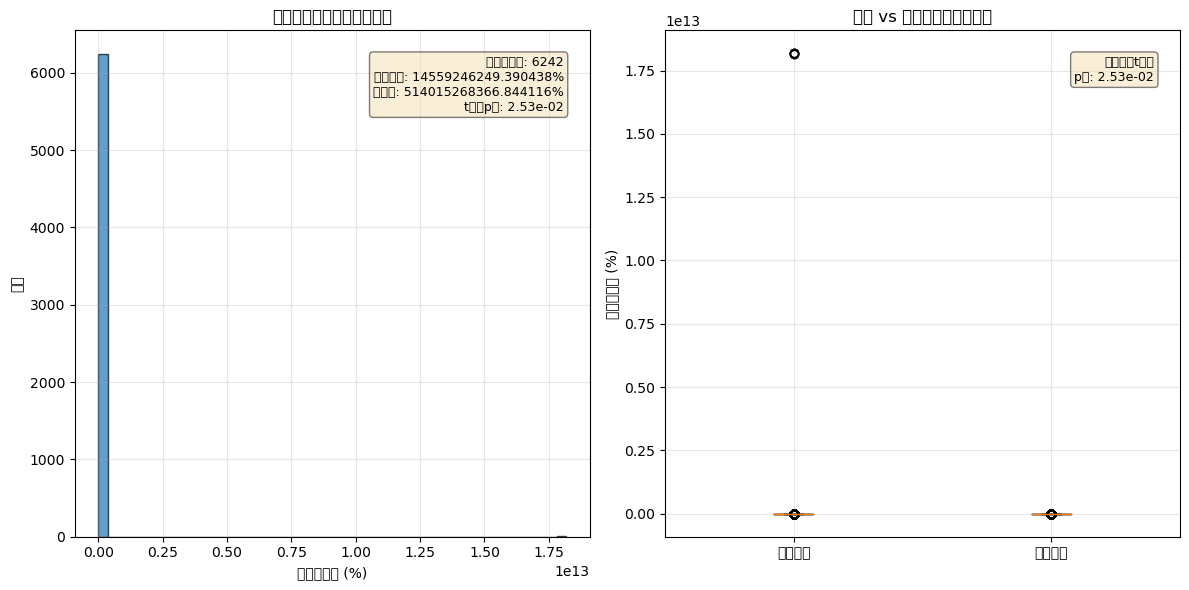

C:\Users\xlf\AppData\Local\Temp\ipykernel_60888\310826676.py:487: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\Users\xlf\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 36164 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\xlf\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 20135 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\xlf\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 20215 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\xlf\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 26684 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\xlf\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 25191

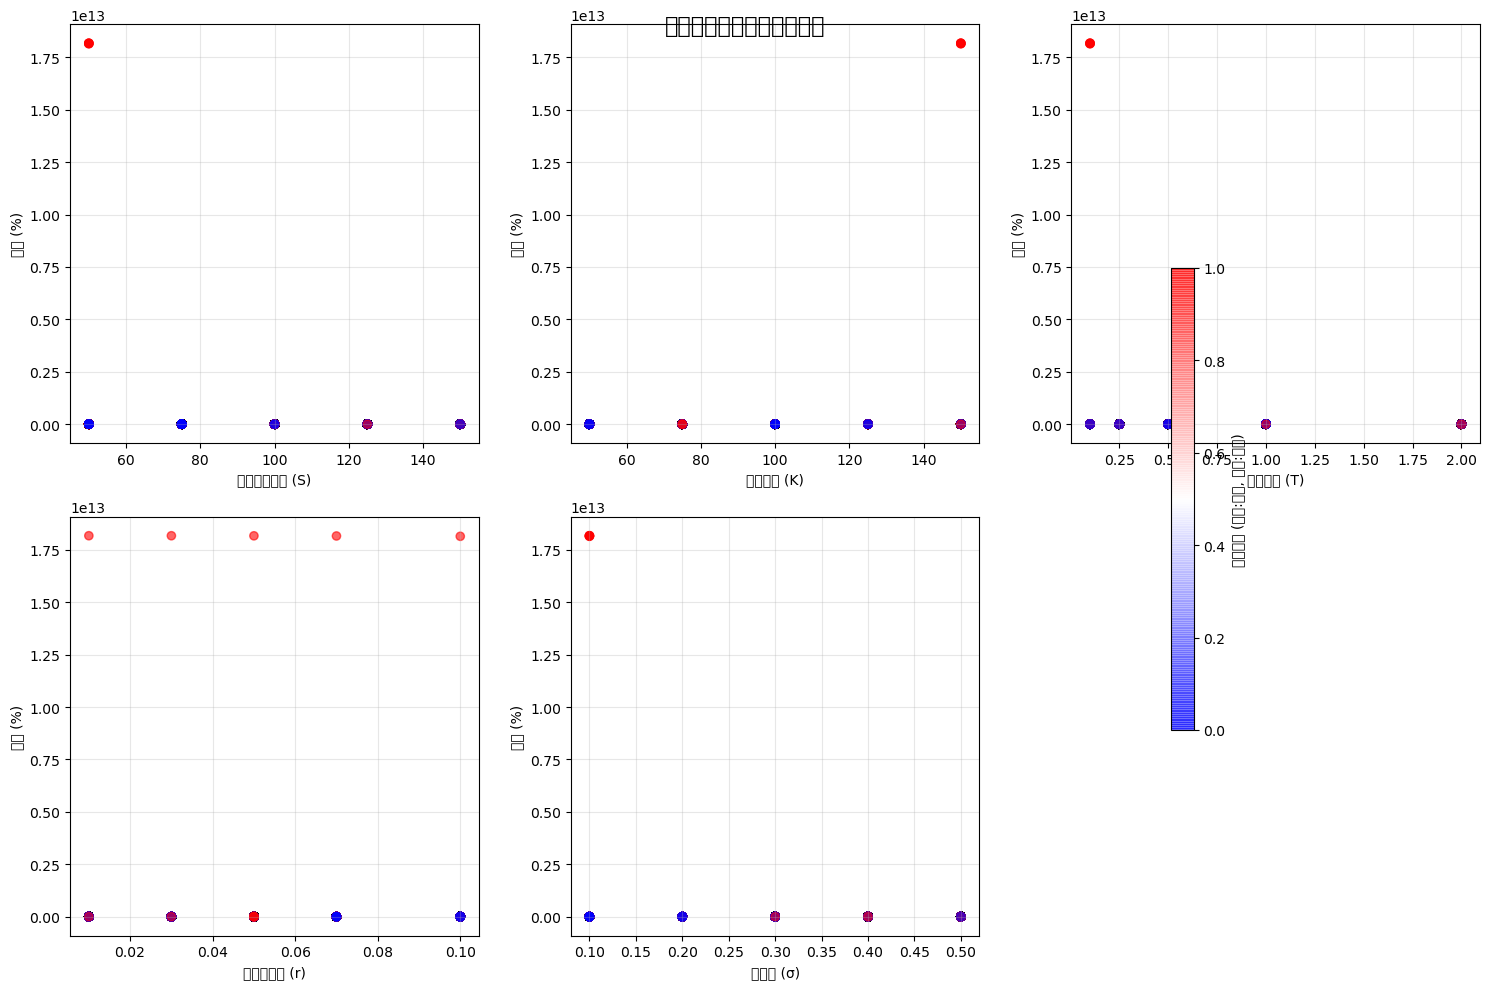


请选择计算模式:
1. 单次计算
2. 参数分析
3. 运行测试
4. 退出


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import sys

# 检查并尝试导入 prettytable
try:
    from prettytable import PrettyTable
    HAS_PRETTYTABLE = True
except ImportError:
    HAS_PRETTYTABLE = False
    print("注意: 未安装 prettytable 库，将使用简单表格格式")

# 检查并尝试导入 QuantLib
try:
    import QuantLib as ql
    HAS_QUANTLIB = True
except ImportError:
    HAS_QUANTLIB = False
    print("注意: 未安装 QuantLib 库，无法进行对比测试")

def black_scholes(S, K, T, r, sigma, option_type='call'):
    """
    计算欧式看涨或看跌期权的Black-Scholes价格
    
    参数:
    S - 标的资产当前价格
    K - 期权执行价格
    T - 到期时间(年)
    r - 无风险利率
    sigma - 波动率
    option_type - 期权类型: 'call' 或 'put'
    
    返回:
    期权价格
    """
    # 计算d1和d2
    if T <= 0:
        # 对于已到期的期权
        if option_type == 'call':
            return max(S - K, 0)
        else:
            return max(K - S, 0)
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type必须是'call'或'put'")
    
    return price

def black_scholes_quantlib(S, K, T, r, sigma, option_type='call'):
    """
    使用QuantLib计算欧式期权价格
    
    参数:
    S - 标的资产当前价格
    K - 期权执行价格
    T - 到期时间(年)
    r - 无风险利率
    sigma - 波动率
    option_type - 期权类型: 'call' 或 'put'
    
    返回:
    期权价格
    """
    if not HAS_QUANTLIB:
        return None
        
    # 设置计算日期
    today = ql.Date().todaysDate()
    ql.Settings.instance().evaluationDate = today
    
    # 创建期权类型
    option = ql.Option.Call if option_type == 'call' else ql.Option.Put
    
    # 创建欧式期权
    payoff = ql.PlainVanillaPayoff(option, K)
    exercise = ql.EuropeanExercise(today + ql.Period(int(T * 365), ql.Days))
    european_option = ql.VanillaOption(payoff, exercise)
    
    # 设置市场数据
    u = ql.SimpleQuote(S)  # 标的资产价格
    r = ql.SimpleQuote(r)  # 无风险利率
    sigma = ql.SimpleQuote(sigma)  # 波动率
    
    # 创建无风险利率曲线
    risk_free_curve = ql.FlatForward(0, ql.TARGET(), ql.QuoteHandle(r), ql.Actual365Fixed())
    volatility = ql.BlackConstantVol(0, ql.TARGET(), ql.QuoteHandle(sigma), ql.Actual365Fixed())
    
    # 创建BS过程
    process = ql.BlackScholesProcess(
        ql.QuoteHandle(u),
        ql.YieldTermStructureHandle(risk_free_curve),
        ql.BlackVolTermStructureHandle(volatility)
    )
    
    # 使用解析定价引擎
    engine = ql.AnalyticEuropeanEngine(process)
    european_option.setPricingEngine(engine)
    
    # 返回价格
    return european_option.NPV()

def print_parameters_table(S, K, T, r, sigma, option_type, price):
    """以表格形式输出参数和价格"""
    if HAS_PRETTYTABLE:
        # 使用 PrettyTable 创建美观的表格
        table = PrettyTable()
        table.field_names = ["参数", "值"]
        table.align["参数"] = "l"
        table.align["值"] = "r"
        
        table.add_row(["标的资产价格 (S)", f"{S:.2f}"])
        table.add_row(["执行价格 (K)", f"{K:.2f}"])
        table.add_row(["到期时间 (T)", f"{T:.4f} 年"])
        table.add_row(["无风险利率 (r)", f"{r:.4f}"])
        table.add_row(["波动率 (σ)", f"{sigma:.4f}"])
        table.add_row(["期权类型", option_type])
        table.add_row(["期权价格", f"{price:.6f}"])
        
        print("\n" + "="*50)
        print("Black-Scholes期权定价结果")
        print("="*50)
        print(table)
    else:
        # 简单的表格格式
        print("\n" + "="*50)
        print("Black-Scholes期权定价结果")
        print("="*50)
        print(f"{'参数':<20} {'值':>30}")
        print(f"{'标的资产价格 (S)':<20} {S:>30.2f}")
        print(f"{'执行价格 (K)':<20} {K:>30.2f}")
        print(f"{'到期时间 (T)':<20} {T:>30.4f} 年")
        print(f"{'无风险利率 (r)':<20} {r:>30.4f}")
        print(f"{'波动率 (σ)':<20} {sigma:>30.4f}")
        print(f"{'期权类型':<20} {option_type:>30}")
        print(f"{'期权价格':<20} {price:>30.6f}")

def single_calculation():
    """单次计算期权价格"""
    print("=== 单次期权定价计算 ===")
    
    # 获取用户输入
    S = float(input("请输入标的资产当前价格: "))
    K = float(input("请输入期权执行价格: "))
    T = float(input("请输入到期时间(年): "))
    r = float(input("请输入无风险利率(小数形式，如0.05表示5%): "))
    sigma = float(input("请输入波动率(小数形式，如0.2表示20%): "))
    option_type = input("请输入期权类型(call/put): ").lower()
    
    # 验证输入
    if option_type not in ['call', 'put']:
        print("错误: 期权类型必须是'call'或'put'")
        return
    
    # 计算期权价格
    price = black_scholes(S, K, T, r, sigma, option_type)
    
    # 输出结果
    print_parameters_table(S, K, T, r, sigma, option_type, price)
    
    # 如果安装了QuantLib，进行对比
    if HAS_QUANTLIB:
        ql_price = black_scholes_quantlib(S, K, T, r, sigma, option_type)
        if ql_price is not None:
            print(f"\nQuantLib计算结果: {ql_price:.6f}")
            print(f"差异: {abs(price - ql_price):.6e}")

def multiple_calculations():
    """多次计算并绘制价格与参数的关系图"""
    print("=== 参数分析模式 ===")
    
    # 获取固定参数
    print("请输入固定参数:")
    S_fixed = float(input("标的资产当前价格: "))
    K_fixed = float(input("期权执行价格: "))
    T_fixed = float(input("到期时间(年): "))
    r_fixed = float(input("无风险利率: "))
    sigma_fixed = float(input("波动率: "))
    option_type = input("期权类型(call/put): ").lower()
    
    # 选择变化参数
    print("\n请选择要分析的参数:")
    print("1. 标的资产价格 (S)")
    print("2. 执行价格 (K)")
    print("3. 到期时间 (T)")
    print("4. 无风险利率 (r)")
    print("5. 波动率 (sigma)")
    
    param_choice = int(input("请输入选项(1-5): "))
    
    # 获取参数范围
    start = float(input("参数起始值: "))
    end = float(input("参数结束值: "))
    steps = int(input("计算点数: "))
    
    # 生成参数值数组
    param_values = np.linspace(start, end, steps)
    prices = []
    
    # 计算不同参数值下的期权价格
    for value in param_values:
        if param_choice == 1:  # S变化
            price = black_scholes(value, K_fixed, T_fixed, r_fixed, sigma_fixed, option_type)
        elif param_choice == 2:  # K变化
            price = black_scholes(S_fixed, value, T_fixed, r_fixed, sigma_fixed, option_type)
        elif param_choice == 3:  # T变化
            price = black_scholes(S_fixed, K_fixed, value, r_fixed, sigma_fixed, option_type)
        elif param_choice == 4:  # r变化
            price = black_scholes(S_fixed, K_fixed, T_fixed, value, sigma_fixed, option_type)
        elif param_choice == 5:  # sigma变化
            price = black_scholes(S_fixed, K_fixed, T_fixed, r_fixed, value, option_type)
        else:
            print("无效选项")
            return
        
        prices.append(price)
    
    # 绘制结果
    param_names = ['标的资产价格 (S)', '执行价格 (K)', '到期时间 (T)', '无风险利率 (r)', '波动率 (σ)']
    param_name = param_names[param_choice - 1]
    
    plt.figure(figsize=(10, 6))
    plt.plot(param_values, prices, 'b-', linewidth=2)
    plt.xlabel(param_name)
    plt.ylabel('期权价格')
    plt.title(f'期权价格 vs {param_name}')
    plt.grid(True)
    plt.show()

def run_tests():
    """运行测试用例，与QuantLib结果对比并进行百分比偏差分析，包括假设检验"""
    if not HAS_QUANTLIB:
        print("未安装QuantLib，无法运行测试")
        return
    
    print("=== 测试模式 ===")
    print("运行大量测试用例，对比自定义实现与QuantLib的结果")
    print("生成测试用例中...")
    
    # 使用列表推导生成大量测试用例
    S_values = [50, 75, 100, 125, 150]
    K_values = [50, 75, 100, 125, 150]
    T_values = [0.1, 0.25, 0.5, 1.0, 2.0]
    r_values = [0.01, 0.03, 0.05, 0.07, 0.1]
    sigma_values = [0.1, 0.2, 0.3, 0.4, 0.5]
    option_types = ['call', 'put']
    
    # 生成所有可能的组合 (5*5*5*5*5*2 = 6250个测试用例)
    test_cases = [
        (S, K, T, r, sigma, option_type)
        for S in S_values
        for K in K_values
        for T in T_values
        for r in r_values
        for sigma in sigma_values
        for option_type in option_types
    ]
    
    print(f"共生成 {len(test_cases)} 个测试用例")
    print("开始测试...")
    
    # 存储所有测试结果
    all_results = []
    call_results = []  # 看涨期权结果
    put_results = []   # 看跌期权结果
    large_deviations = []  # 存储偏差较大的测试用例
    
    # 运行测试
    for i, (S, K, T, r, sigma, option_type) in enumerate(test_cases):
        # 计算价格
        our_price = black_scholes(S, K, T, r, sigma, option_type)
        ql_price = black_scholes_quantlib(S, K, T, r, sigma, option_type)
        
        # 跳过无效结果
        if ql_price is None or ql_price == 0:
            continue
            
        # 计算百分比偏差
        deviation = ((our_price - ql_price) / ql_price) * 100  # 保留正负号
        
        # 存储结果
        all_results.append(deviation)
        
        if option_type == 'call':
            call_results.append(deviation)
        else:
            put_results.append(deviation)
        
        # 如果绝对偏差超过阈值，记录详细信息
        if abs(deviation) > 0.1:  # 0.1%的阈值
            large_deviations.append({
                'S': S, 'K': K, 'T': T, 'r': r, 'sigma': sigma, 
                'type': option_type, 'our_price': our_price, 
                'ql_price': ql_price, 'deviation': deviation
            })
        
        # 显示进度
        if (i + 1) % 1000 == 0:
            print(f"已完成 {i + 1}/{len(test_cases)} 个测试用例")
    
    # 计算统计信息
    if all_results:
        # 基本统计
        avg_deviation = np.mean(all_results)
        max_deviation = np.max(all_results)
        min_deviation = np.min(all_results)
        std_deviation = np.std(all_results)
        
        # 看涨/看跌期权的统计
        call_avg = np.mean(call_results) if call_results else 0
        call_std = np.std(call_results) if call_results else 0
        put_avg = np.mean(put_results) if put_results else 0
        put_std = np.std(put_results) if put_results else 0
        
        # 输出统计结果
        print("\n=== 测试结果统计 ===")
        print(f"测试用例总数: {len(test_cases)}")
        print(f"有效结果数: {len(all_results)}")
        print(f"平均偏差: {avg_deviation:.6f}%")
        print(f"最大偏差: {max_deviation:.6f}%")
        print(f"最小偏差: {min_deviation:.6f}%")
        print(f"标准差: {std_deviation:.6f}%")
        
        print(f"\n看涨期权平均偏差: {call_avg:.6f}% (标准差: {call_std:.6f}%)")
        print(f"看跌期权平均偏差: {put_avg:.6f}% (标准差: {put_std:.6f}%)")
        
        # 偏差分布
        print("\n偏差分布:")
        bins = [-100, -10, -1, -0.1, -0.01, 0, 0.01, 0.1, 1, 10, 100]
        hist, bin_edges = np.histogram(all_results, bins=bins)
        for i in range(len(hist)):
            print(f"{bin_edges[i]:.3f}% - {bin_edges[i+1]:.3f}%: {hist[i]} 个用例 ({hist[i]/len(all_results)*100:.1f}%)")
        
        # 假设检验 - 检验偏差均值是否显著不为0
        from scipy import stats
        
        # 对所有偏差进行单样本t检验
        t_stat, p_value = stats.ttest_1samp(all_results, 0)
        print(f"\n假设检验 (所有偏差):")
        print(f"t统计量: {t_stat:.6f}, p值: {p_value:.6e}")
        if p_value < 0.05:
            print("结果: 偏差均值显著不为0 (p < 0.05)")
            if avg_deviation > 0:
                print("我们的实现系统性地高估了期权价格")
            else:
                print("我们的实现系统性地低估了期权价格")
        else:
            print("结果: 偏差均值与0无显著差异 (p >= 0.05)")
        
        # 对看涨和看跌期权的偏差进行独立样本t检验
        if call_results and put_results:
            t_stat2, p_value2 = stats.ttest_ind(call_results, put_results, equal_var=False)
            print(f"\n假设检验 (看涨 vs 看跌):")
            print(f"t统计量: {t_stat2:.6f}, p值: {p_value2:.6e}")
            if p_value2 < 0.05:
                print("结果: 看涨和看跌期权的偏差有显著差异 (p < 0.05)")
            else:
                print("结果: 看涨和看跌期权的偏差无显著差异 (p >= 0.05)")
        
        # 输出偏差较大的测试用例
        if large_deviations:
            print(f"\n发现 {len(large_deviations)} 个绝对偏差超过 0.1% 的测试用例:")
            
            # 按偏差大小排序
            large_deviations.sort(key=lambda x: abs(x['deviation']), reverse=True)
            
            if HAS_PRETTYTABLE:
                table = PrettyTable()
                table.field_names = ["S", "K", "T", "r", "σ", "类型", "我们的价格", "QuantLib价格", "偏差(%)"]
                for case in large_deviations[:10]:  # 只显示前10个
                    table.add_row([
                        case['S'], case['K'], case['T'], case['r'], case['sigma'],
                        case['type'], f"{case['our_price']:.6f}", 
                        f"{case['ql_price']:.6f}", f"{case['deviation']:.6f}"
                    ])
                print(table)
                
                if len(large_deviations) > 10:
                    print(f"... 还有 {len(large_deviations) - 10} 个用例未显示")
            else:
                print(f"{'S':<5} {'K':<5} {'T':<5} {'r':<5} {'σ':<5} {'类型':<5} {'我们的价格':<12} {'QuantLib价格':<12} {'偏差(%)':<10}")
                print("-" * 70)
                for case in large_deviations[:10]:  # 只显示前10个
                    print(f"{case['S']:<5} {case['K']:<5} {case['T']:<5.2f} {case['r']:<5.2f} {case['sigma']:<5.2f} "
                          f"{case['type']:<5} {case['our_price']:<12.6f} {case['ql_price']:<12.6f} {case['deviation']:<10.6f}")
                
                if len(large_deviations) > 10:
                    print(f"... 还有 {len(large_deviations) - 10} 个用例未显示")
        
        # 绘制偏差分布直方图
        plt.figure(figsize=(12, 6))
        
        # 所有偏差的直方图
        plt.subplot(1, 2, 1)
        plt.hist(all_results, bins=50, edgecolor='black', alpha=0.7)
        plt.xlabel('百分比偏差 (%)')
        plt.ylabel('频率')
        plt.title('所有期权的百分比偏差分布')
        plt.grid(True, alpha=0.3)
        
        # 添加统计信息文本框
        textstr = '\n'.join([
            f'测试用例数: {len(all_results)}',
            f'平均偏差: {avg_deviation:.6f}%',
            f'标准差: {std_deviation:.6f}%',
            f't检验p值: {p_value:.2e}'
        ])
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        plt.text(0.95, 0.95, textstr, transform=plt.gca().transAxes, fontsize=9,
                verticalalignment='top', horizontalalignment='right', bbox=props)
        
        # 看涨和看跌期权的箱线图比较
        plt.subplot(1, 2, 2)
        data = [call_results, put_results]
        plt.boxplot(data, labels=['看涨期权', '看跌期权'])
        plt.title('看涨 vs 看跌期权的偏差比较')
        plt.ylabel('百分比偏差 (%)')
        plt.grid(True, alpha=0.3)
        
        # 添加t检验结果
        if call_results and put_results:
            textstr2 = f'独立样本t检验\np值: {p_value2:.2e}'
            plt.text(0.95, 0.95, textstr2, transform=plt.gca().transAxes, fontsize=9,
                    verticalalignment='top', horizontalalignment='right', bbox=props)
        
        plt.tight_layout()
        plt.show()
        
        # 绘制偏差与各参数的关系散点图
        if large_deviations:
            fig, axes = plt.subplots(2, 3, figsize=(15, 10))
            fig.suptitle('大偏差用例的参数分布分析', fontsize=16)
            
            # 提取大偏差用例的参数
            S_vals = [case['S'] for case in large_deviations]
            K_vals = [case['K'] for case in large_deviations]
            T_vals = [case['T'] for case in large_deviations]
            r_vals = [case['r'] for case in large_deviations]
            sigma_vals = [case['sigma'] for case in large_deviations]
            deviations = [case['deviation'] for case in large_deviations]
            types = [1 if case['type'] == 'call' else 0 for case in large_deviations]  # 将类型转换为数值
            
            # S vs 偏差
            scatter = axes[0, 0].scatter(S_vals, deviations, c=types, cmap='bwr', alpha=0.6)
            axes[0, 0].set_xlabel('标的资产价格 (S)')
            axes[0, 0].set_ylabel('偏差 (%)')
            axes[0, 0].grid(True, alpha=0.3)
            
            # K vs 偏差
            axes[0, 1].scatter(K_vals, deviations, c=types, cmap='bwr', alpha=0.6)
            axes[0, 1].set_xlabel('执行价格 (K)')
            axes[0, 1].set_ylabel('偏差 (%)')
            axes[0, 1].grid(True, alpha=0.3)
            
            # T vs 偏差
            axes[0, 2].scatter(T_vals, deviations, c=types, cmap='bwr', alpha=0.6)
            axes[0, 2].set_xlabel('到期时间 (T)')
            axes[0, 2].set_ylabel('偏差 (%)')
            axes[0, 2].grid(True, alpha=0.3)
            
            # r vs 偏差
            axes[1, 0].scatter(r_vals, deviations, c=types, cmap='bwr', alpha=0.6)
            axes[1, 0].set_xlabel('无风险利率 (r)')
            axes[1, 0].set_ylabel('偏差 (%)')
            axes[1, 0].grid(True, alpha=0.3)
            
            # sigma vs 偏差
            axes[1, 1].scatter(sigma_vals, deviations, c=types, cmap='bwr', alpha=0.6)
            axes[1, 1].set_xlabel('波动率 (σ)')
            axes[1, 1].set_ylabel('偏差 (%)')
            axes[1, 1].grid(True, alpha=0.3)
            
            # 添加颜色条
            cbar = fig.colorbar(scatter, ax=axes.ravel().tolist(), shrink=0.6)
            cbar.set_label('期权类型 (红色:看涨, 蓝色:看跌)')
            
            # 隐藏最后一个子图
            axes[1, 2].set_visible(False)
            
            plt.tight_layout()
            plt.show()
    else:
        print("没有有效的测试结果")

def main():
    """主函数"""
    print("Black-Scholes期权定价模型")
    
    while True:
        print("\n请选择计算模式:")
        print("1. 单次计算")
        print("2. 参数分析")
        if HAS_QUANTLIB:
            print("3. 运行测试")
            print("4. 退出")
        else:
            print("3. 退出")
        
        choice = input("请输入选项: ")
        
        if choice == '1':
            single_calculation()
        elif choice == '2':
            multiple_calculations()
        elif choice == '3' and HAS_QUANTLIB:
            run_tests()
        elif choice == '3' and not HAS_QUANTLIB or choice == '4':
            print("程序已退出")
            break
        else:
            print("无效选项，请重新选择")

if __name__ == "__main__":
    main()